In [1]:
import itertools
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import f1_score
import multiprocessing as mp
import os

In [2]:
# Test different feature vectors for each sequence
d = {'A':0,'G':1,'C':2,'T':3}

# Construct k-mer dictionary
kmer_to_ind = {}
ind_to_kmer = {}
k_ind = 0
for k in range(1,6):
    for kmer in [''.join(i) for i in itertools.product('ACGT', repeat = k)]:
        kmer_to_ind[kmer] = k_ind
        ind_to_kmer[k_ind] = kmer
        k_ind += 1

# Feature mapping 1: char to int
def seq_to_int(s):
    return map(lambda x: d[x], s)

# Feature mapping 2: k-mer counting for k = 1, 2, 3, 4, 5
def kmer_count(s):
    v = np.zeros(len(kmer_to_ind))
    for k in range(1,6):
        for kmer in [s[i:i+k] for i in range(len(s)-k+1)]:
            v[kmer_to_ind[kmer]] += 1
    return v

In [5]:
def load_features(feature_extractor,filename,num_steps=100):
    # Read in sequence
    f = open(filename)
    X = []
    start_time = time.time()
    for i,line in enumerate(f):
        if i % 1000 == 0:
            print time.time()-start_time, ' s'
        s = line.split()[0]
        a = int(len(s)/2-num_steps/2)
        b = int(len(s)/2+num_steps/2)
        X.append(feature_extractor(s[a:b]))
    return np.array(X)
  
fileprefix = '../jz-rnn-tensorflow/data/deepsea_multitask/deepsea'
feature_extractor = kmer_count

X_test = load_features(feature_extractor,fileprefix + '.data.test.txt')
X_train = load_features(feature_extractor,fileprefix + '.data.train.txt')
Y_test = np.loadtxt(fileprefix + '.labels.test.txt')
Y_train = np.loadtxt(fileprefix + '.labels.train.txt')

pickle.dump((X_test,X_train,Y_test,Y_train),file('data_100.pickle','wb'))
# X_test,X_train,Y_test,Y_train = pickle.load(file('data.pickle','rb'))

2.69412994385e-05  s
0.968059062958  s
1.99209499359  s
3.03894615173  s
4.05288505554  s
4.98246002197  s
5.93528294563  s
6.92225408554  s
3.60012054443e-05  s
0.960997104645  s
1.95629501343  s
2.95663404465  s
3.9499669075  s
4.93707704544  s
5.90225291252  s
6.86880397797  s
7.8530330658  s
8.84818005562  s
9.81141996384  s
10.7867441177  s
11.7530751228  s
12.7159020901  s
13.6790099144  s
14.6328239441  s
15.5963909626  s
16.5594980717  s
17.5143918991  s
18.4769620895  s
19.4396719933  s
20.4090790749  s
21.3746099472  s
22.3359029293  s
23.2926111221  s
24.2551169395  s
25.2237000465  s
26.1800720692  s
27.1372199059  s
28.0939500332  s
29.048386097  s
30.0454421043  s
31.0230638981  s
31.9819021225  s
32.9068980217  s
33.8036880493  s
34.7173790932  s
35.5976510048  s
36.4815890789  s
37.3687939644  s
38.2542049885  s
39.1374299526  s
40.0120840073  s
40.8877439499  s
41.7761280537  s
42.6560769081  s
43.5349879265  s
44.4158270359  s
45.2893660069  s
46.1723070145  s
47.0548

In [6]:
print np.shape(X_test),np.shape(X_train),np.shape(Y_test),np.shape(Y_train)

(8000, 1364) (80000, 1364) (8000, 919) (80000, 919)


In [7]:
# logistic regression model

def logistic_reg(inputs):
    X_test,X_train,Y_test,Y_train,i = inputs
    logreg = linear_model.LogisticRegression(C=1e6)
    logreg.fit(X_train, Y_train)
    Yhat_train = logreg.predict(X_train)
    Yhat_test = logreg.predict(X_test)
    f1_train = f1_score(Y_train,Yhat_train)
    f1_test = f1_score(Y_test,Yhat_test)
    f = open('logistic_regression_results/'+str(i))
    f.write('%.3f\t%.3f\n'%(f1_train,f1_test))
    f.close()
    return f1_train,f1_test

In [ ]:
num_tasks = np.shape(Y_train)[1]

all_f1_train = []
all_f1_test = []
start_time = time.time()
for i in range(num_tasks):
    inputs = (X_test,X_train,Y_test[:,i],Y_train[:,i])
    f1_train,f1_test = logistic_reg(inputs)
    all_f1_train.append(f1_train)
    all_f1_test.append(f1_test)
    f = open('logistic_regression_results','a')
    f.write('Task ' + str(i) + ':\tf1 train = %.3f\tf1 test = %.3f\n'%(f1_train,f1_test))
    f.close()
    print 'Task ' + str(i) + ':\tf1 train = %.3f\tf1 test = %.3f'%(f1_train,f1_test) 
    print time.time()-start_time

In [ ]:
num_tasks = np.shape(Y_train)[1]
all_inputs = [(X_test,X_train,Y_test[:,i],Y_train[:,i],i) for i in range(num_tasks)]
pool=mp.Pool(processes=40)
pool.map(logistic_reg,all_inputs)

## Logistic Regression Output Analysis

In [5]:
# Analysis 
bad_files = np.zeros(919)
train_counts = np.zeros(919)
test_counts = np.zeros(919)
f1_scores = np.ones(919)*-1

X = np.zeros([919,5])

for i in range(919):
    f = open('logistic_regression_100_results/'+str(i))
    for line in f:
        z = line.split()
    X[i,0] = i
    X[i,1] = float(z[0])
    X[i,2] = float(z[1])
    if len(z) > 3:
        X[i,3] = float(z[2])
        X[i,4] = float(z[3])
    else:
        X[i,3] = -1
        X[i,4] = -1
        
print X
    

[[  0.00000000e+00   3.16300000e+03   3.14000000e+02   8.00000000e-02
    5.90000000e-02]
 [  1.00000000e+00   3.26200000e+03   3.18000000e+02   3.30000000e-02
    1.80000000e-02]
 [  2.00000000e+00   2.41800000e+03   2.46000000e+02   7.50000000e-02
    2.30000000e-02]
 ..., 
 [  9.16000000e+02   7.50100000e+03   7.43000000e+02   3.40000000e-01
    3.18000000e-01]
 [  9.17000000e+02   7.99400000e+03   7.73000000e+02   1.00000000e-03
    3.00000000e-03]
 [  9.18000000e+02   9.99000000e+02   1.01000000e+02   6.00000000e-03
    0.00000000e+00]]


(array([ 427.,  214.,   82.,   50.,   52.,   34.,   13.,   12.,    8.,
           7.,    6.,    4.,    2.,    0.,    1.,    2.,    1.,    2.,
           1.,    1.]),
 array([    0.  ,    79.65,   159.3 ,   238.95,   318.6 ,   398.25,
          477.9 ,   557.55,   637.2 ,   716.85,   796.5 ,   876.15,
          955.8 ,  1035.45,  1115.1 ,  1194.75,  1274.4 ,  1354.05,
         1433.7 ,  1513.35,  1593.  ]),
 <a list of 20 Patch objects>)

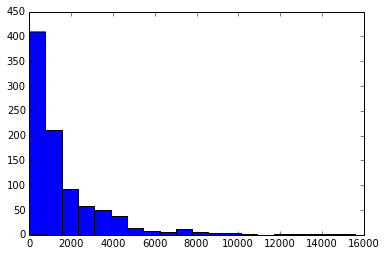

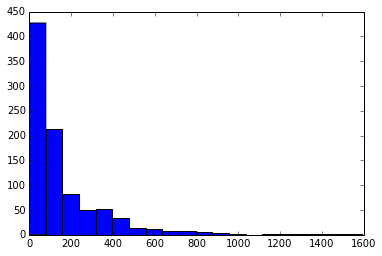

In [6]:
%matplotlib inline

# Histograms of total # of 1's in labels
plt.hist(X[:,1],bins=20)
plt.figure()
plt.hist(X[:,2],bins=20)

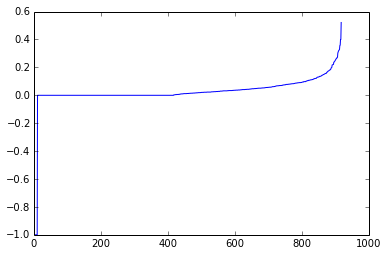

In [7]:
# Plot of F1 scores in sorted order
plt.plot(np.sort(X[:,4]))

In [25]:
a = sorted([(val,i,X[i,1]/float(80000)) for i,val in enumerate(X[:,4])])
a.reverse()
good_inds = np.array([i[1] for i in a])

## Neural Network Analysis

In [9]:
# Copy over validation errors from training model
import os
key = '54.153.39.112'
os.system('scp -i ../cs224d.pem ubuntu@'+key+':deep_learning_genomics_nlp/jz-rnn-tensorflow/weights/validation_errors ../jz-rnn-tensorflow/aws_weights/')

0

In [23]:
# f = open('../jz-rnn-tensorflow/aws_weights/weights1/validation_errors')
f = open('../jz-rnn-tensorflow/aws_weights/validation_errors')

F1 = []
for line in f:
    z = line.split('\t')
    F1.append([float(i) for i in z[3].translate(None,'[').translate(None,']').translate(None,'\n').split(',')])
F1 = np.array(F1)

In [27]:
# Print out the max F1 for each of logistic regressions best-performing tasks
n = 100
for j,(i,k) in enumerate([(np.max(F1[:,good_inds[i]]),np.argmax(F1[:,good_inds[i]])) 
                          for i in range(n)]): print '%d\t%3f\t%3f'%(k,i,a[j][0]), a[j][2]*80000

13	0.511211	0.522000 5410.0
0	0.000000	0.400000 22.0
0	0.000000	0.400000 38.0
15	0.371681	0.359000 6527.0
15	0.431138	0.357000 4354.0
11	0.353933	0.329000 9322.0
2	0.342857	0.325000 3851.0
22	0.349810	0.322000 7545.0
23	0.330709	0.318000 7501.0
15	0.332075	0.311000 7140.0
11	0.313043	0.303000 9684.0
8	0.417910	0.273000 1569.0
7	0.279412	0.271000 3535.0
22	0.244344	0.266000 5876.0
19	0.400000	0.266000 1373.0
11	0.276364	0.261000 7230.0
21	0.284790	0.258000 8599.0
15	0.261803	0.254000 13762.0
5	0.444444	0.250000 504.0
5	0.405797	0.245000 1658.0
2	0.170213	0.241000 907.0
2	0.324561	0.239000 5933.0
6	0.310000	0.238000 5529.0
0	0.000000	0.222000 172.0
11	0.250000	0.220000 7283.0
19	0.258065	0.220000 678.0
6	0.329670	0.219000 2219.0
11	0.243421	0.217000 8530.0
0	0.000000	0.200000 41.0
11	0.217284	0.198000 12573.0
2	0.260870	0.196000 5530.0
24	0.333333	0.188000 939.0
6	0.400000	0.185000 743.0
0	0.000000	0.182000 316.0
22	0.148148	0.182000 764.0
21	0.274809	0.181000 4125.0
1	0.060606	0.178000 

In [15]:
# Print out the 
for j in range(len(F1)):
    print 'Line '+str(j)
    for i in range(10):
        print '%3f\t%3f'%(F1[j,good_inds[i]],a[i][0])
    print '-'*80

Line 0
0.219653	0.522000
0.000000	0.400000
0.000000	0.400000
0.131148	0.359000
0.209790	0.357000
0.052045	0.329000
0.133333	0.325000
0.048544	0.322000
0.167401	0.318000
0.074419	0.311000
--------------------------------------------------------------------------------
Line 1
0.363636	0.522000
0.000000	0.400000
0.000000	0.400000
0.206278	0.359000
0.197674	0.357000
0.224852	0.329000
0.173913	0.325000
0.231884	0.322000
0.186770	0.318000
0.176245	0.311000
--------------------------------------------------------------------------------
Line 2
0.420601	0.522000
0.000000	0.400000
0.000000	0.400000
0.290598	0.359000
0.345946	0.357000
0.258824	0.329000
0.342857	0.325000
0.250000	0.322000
0.323529	0.318000
0.288809	0.311000
--------------------------------------------------------------------------------
Line 3
0.377551	0.522000
0.000000	0.400000
0.000000	0.400000
0.204082	0.359000
0.125000	0.357000
0.182432	0.329000
0.119658	0.325000
0.240000	0.322000
0.183406	0.318000
0.181034	0.311000
---------